# Wrist decoder evaluation

In [1]:
import os
import glob
import torch
from pytorch_lightning import Trainer
from hydra import initialize, compose
from hydra.utils import instantiate
import omegaconf
from matplotlib import pyplot as plt
import seaborn as sns
import h5py
from generic_neuromotor_interface.constants import Task

/Users/ronuchit/miniconda3/envs/neuromotor/lib/python3.12/site-packages/lightning_lite/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


## Establish paths to data and model files

Before running this notebook you must make sure to download the data and model checkpoint as follows:
```
cd ~/generic-neuromotor-interface-data

./download_data.sh wrist small_subset <EMG_DATA_DIR>  # or full_data instead of small_subset

./download_models.sh wrist <MODELS_DIR>
```
where `<EMG_DATA_DIR>` and `<MODELS_DIR>` should match the directory specified by the `EMG_DATA_DIR` and `MODELS_DIR` variables defined in the next cell.

In [2]:
EMG_DATA_DIR = "~/emg_data/"  # path to EMG data
MODELS_DIR = "~/emg_models/"  # path to model files

## Load model checkpoint and config

In [3]:
"""Retrieve model checkpoint"""

model_ckpt_path = os.path.join(os.path.expanduser(MODELS_DIR), "wrist", "model_checkpoint.ckpt")
model_ckpt = torch.load(
    model_ckpt_path,
    map_location=torch.device("cpu")
)

/tmp/ipykernel_28826/3072726434.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ckpt = torch.load(


In [4]:
"""Retrieve the config"""

config_path = os.path.relpath(os.path.join(os.path.expanduser(MODELS_DIR), "wrist"))
with initialize(config_path=config_path):
    cfg = compose(config_name="model_config")

/tmp/ipykernel_28826/585771279.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=config_path):


## Instantiate model and data module

In [5]:
"""Load the model"""

# Instantiate model
model = instantiate(cfg.lightning_module)

# Load the checkpoint state_dict
model.load_state_dict(model_ckpt["state_dict"])

/Users/ronuchit/miniconda3/envs/neuromotor/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
  rank_zero_warn(


<All keys matched successfully>

In [6]:
"""Assemble the data module"""

# Assemble DataModule config
datamodule_cfg = omegaconf.OmegaConf.to_container(cfg.data_module)
datamodule_cfg["data_location"] = EMG_DATA_DIR
datamodule_cfg["data_split"]["csv_filename"] = os.path.join(EMG_DATA_DIR, "wrist_corpus.csv")

# Instantiate DataModule
datamodule = instantiate(datamodule_cfg)

## Run inference on one test stage

In [7]:
"""Grab one test stage"""

test_dataset = datamodule._make_dataset({"wrist_user_002_dataset_000": [(1713966045.6641605, 1713966207.9896057)]}, "test")  # from wrist_mini_split.yaml
sample = test_dataset[0]

In [8]:
"""Run inference"""

EMG_SAMPLING_RATE = 2000.

model_output_sampling_rate = EMG_SAMPLING_RATE / model.network.stride

model.eval()

# unpack sample
emg = sample["emg"]
wrist_angles = sample["wrist_angles"]

# compute model outputs
with torch.no_grad():
    predictions = model(emg.unsqueeze(0))

predictions = predictions[0]

# convert wrist angle units from radians to degrees
wrist_angles = torch.rad2deg(wrist_angles)
predictions = torch.rad2deg(predictions)

# convert model predictions from displacements (deg) to velocities (deg/sec)
predictions *= model_output_sampling_rate

# estimate wrist angle velocities with the displacement across
# adjacent wrist angle measurements
wrist_angles_sliced = wrist_angles[:, model.network.left_context :: model.network.stride]  # slice the wrist angles at the model output sampling rate
wirst_angle_displacements = torch.diff(wrist_angles_sliced, dim=1)
wrist_angle_velocities = wirst_angle_displacements * model_output_sampling_rate  # convert to deg/sec

# since we don't know the true displacement at the first timestep, remove the first prediction
predictions = predictions[:, 1:]

In [9]:
"""Evaluate Mean Absolute Error (MAE)"""

mae = torch.mean(torch.abs(predictions - wrist_angle_velocities))

print(f"MAE on this stage: {mae:.3f} (deg/sec)")

MAE on this dataset: 11.091 (deg/sec)


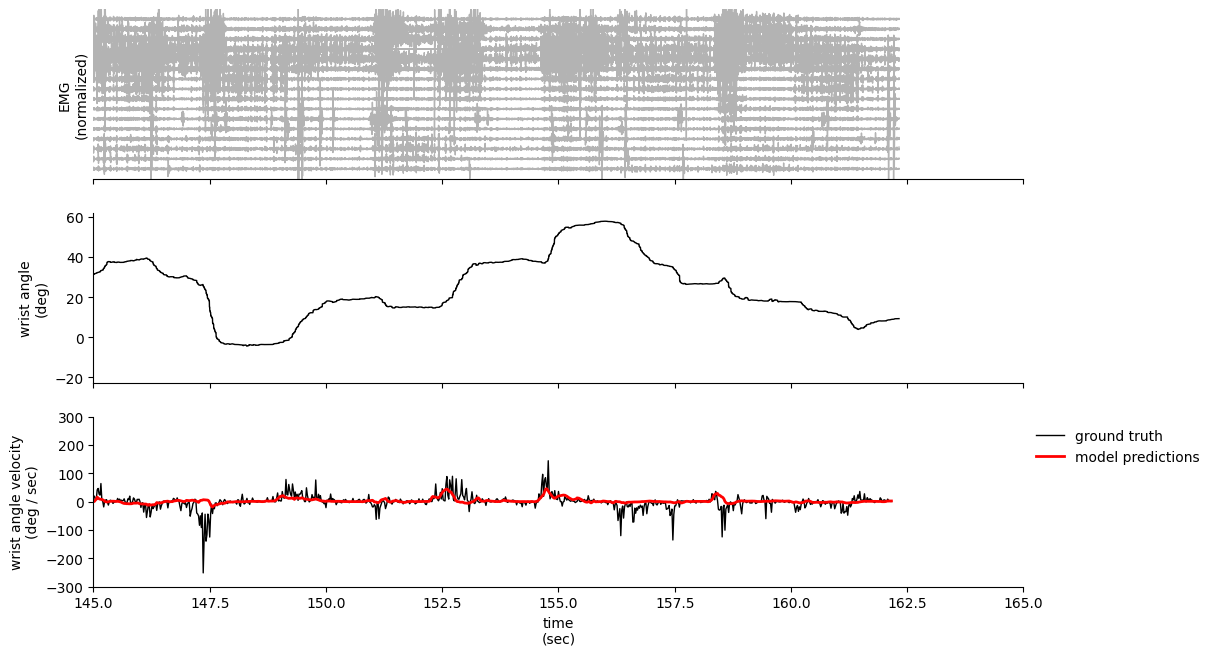

In [10]:
"""Plot predictions and targets"""

fig, axes = plt.subplots(3, 1, figsize=(12, 7.5), sharex=True, sharey=False)

# plot EMG
ax = axes[0]
spacing = 120
for channel_index, channel_data in enumerate(emg):
    ax.plot(
        torch.arange(len(channel_data)) / EMG_SAMPLING_RATE,
        channel_data + channel_index * spacing,
        linewidth=1,
        color="0.7",
    )
ax.set_ylim([-spacing, len(emg) * spacing])
ax.set_yticks([])

sns.despine(ax=ax, left=True)

# wrist angles
ax = axes[1]
assert wrist_angles.shape[0] == 1
ax.plot(
    torch.arange(wrist_angles.shape[1]) / EMG_SAMPLING_RATE,
    wrist_angles[0],
    linewidth=1,
    color="k",
)
sns.despine(ax=ax)

# wrist angle velocities
ax = axes[2]
assert wrist_angle_velocities.shape[0] == 1
ax.plot(
    torch.arange(wrist_angle_velocities.shape[1]) / model_output_sampling_rate,
    wrist_angle_velocities[0],
    linewidth=1,
    color="k",
    label="ground truth",
)
sns.despine(ax=ax)

# model predictions
assert predictions.shape[0] == 1
ax.plot(
    torch.arange(predictions.shape[1]) / model_output_sampling_rate,
    predictions[0],
    linewidth=2,
    color="r",
    label="model predictions",
)

ax.legend(
    loc="upper left",
    ncols=1,
    bbox_to_anchor=(1.0, 1.0),
    frameon=False
)
ax.set_ylim([-300, 300])

ax.set_xlim([145, 165])

axes[0].set_ylabel("EMG\n(normalized)")
axes[1].set_ylabel("wrist angle\n(deg)")
axes[2].set_ylabel("wrist angle velocity\n(deg / sec)")
axes[2].set_xlabel("time\n(sec)");

## Evaluate full test set

Note that this requires you to have downloaded the full dataset (`full_data` instead of `small_subset`) when invoking `./download_data.sh`.

In [11]:
trainer = Trainer()
test_results = trainer.test(model=model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ronuchit/miniconda3/envs/neuromotor/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/ronuchit/emg_data/wrist_user_095_dataset_000.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)